## Dependencies

In [1]:
import json, warnings, shutil, glob
from jigsaw_utility_scripts import *
from scripts_step_lr_schedulers import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [2]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [3]:
database_base_path = '/kaggle/input/jigsaw-data-split-roberta-192-ratio-2-upper45/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", 
                       usecols=['comment_text', 'toxic', 'lang'])

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print('Validation samples: %d' % len(valid_df))
display(valid_df.head())

base_data_path = 'fold_5/'
fold_n = 5
# Unzip files
!tar -xf /kaggle/input/jigsaw-data-split-roberta-192-ratio-2-upper45/fold_5.tar.gz

Train samples: 400830


,comment_text,toxic,toxic_int,length,word_count,token_count,fold_1,fold_2,fold_3,fold_4,fold_5
0,And you have something alien on your lips Chan...,0.000000,0,146,28,40,train,train,validation,train,train
1,no income tax for anyone that comes and works ...,0.166667,0,154,30,41,train,train,train,train,validation
2,"Rubbish, Brandon. Nothing stopped Comey of the...",0.833333,1,444,75,105,train,train,validation,train,train
3,poster I have sent the e-mail. -Garrett,0.000000,0,39,7,14,train,train,validation,train,train
4,== ECB exposure == I responded to a comment of...,0.000000,0,66,13,23,train,train,validation,train,train


Validation samples: 8000


,comment_text,lang,toxic
0,Este usuario ni siquiera llega al rango de ...,es,0
1,Il testo di questa voce pare esser scopiazzato...,it,0
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


# Model parameters

In [4]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 192,
  "BATCH_SIZE": 128,
  "EPOCHS": 4,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": None,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

## Learning rate schedule

Learning rate schedule: 1e-07 to 9.84e-06 to 1.06e-06


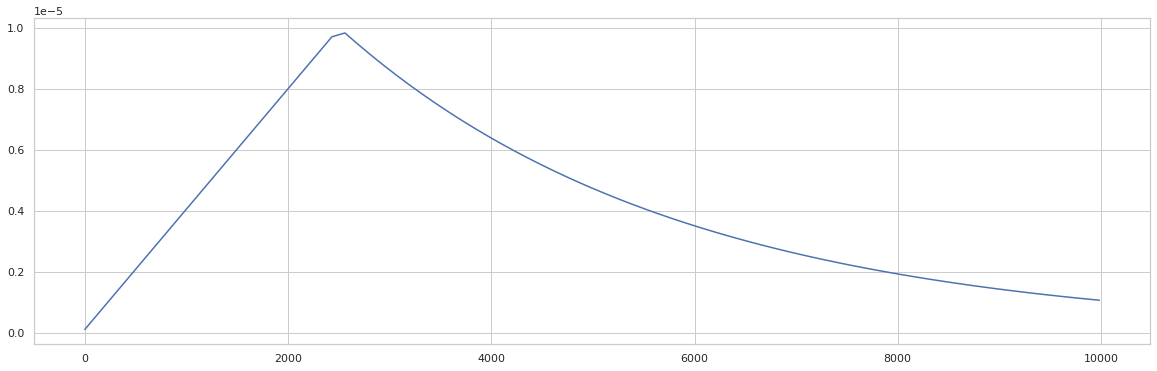

In [5]:
lr_min = 1e-7
lr_start = 1e-7
lr_max = config['LEARNING_RATE']
step_size = len(k_fold[k_fold[f'fold_{fold_n}'] == 'train']) // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 1
decay = .9997

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps, hold_max_steps, 
                                      lr_start, lr_max, lr_min, decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [6]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    cls_token = last_hidden_state[:, 0, :]
    
    output = layers.Dense(1, activation='sigmoid', name='output')(cls_token)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

# Train

In [7]:
# Load data
x_train = np.load(base_data_path + 'x_train.npy')
y_train = np.load(base_data_path + 'y_train_int.npy').reshape(x_train.shape[1], 1).astype(np.float32)
x_valid_ml = np.load(database_base_path + 'x_valid.npy')
y_valid_ml = np.load(database_base_path + 'y_valid.npy').reshape(x_valid_ml.shape[1], 1).astype(np.float32)

#################### ADD TAIL ####################
x_train = np.hstack([x_train, np.load(base_data_path + 'x_train_tail.npy')])
y_train = np.vstack([y_train, y_train])

step_size = x_train.shape[1] // config['BATCH_SIZE']
valid_step_size = x_valid_ml.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
train_data_iter = iter(train_dist_ds)
valid_data_iter = iter(valid_dist_ds)

# Step functions
@tf.function
def train_step(data_iter):
    def train_step_fn(x, y):
        with tf.GradientTape() as tape:
            probabilities = model(x, training=True)
            loss = loss_fn(y, probabilities)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_auc.update_state(y, probabilities)
        train_loss.update_state(loss)
    for _ in tf.range(step_size):
        strategy.experimental_run_v2(train_step_fn, next(data_iter))

@tf.function
def valid_step(data_iter):
    def valid_step_fn(x, y):
        probabilities = model(x, training=False)
        loss = loss_fn(y, probabilities)
        valid_auc.update_state(y, probabilities)
        valid_loss.update_state(loss)
    for _ in tf.range(valid_step_size):
        strategy.experimental_run_v2(valid_step_fn, next(data_iter))

# Train model
with strategy.scope():
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: 
                                exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                 warmup_steps, hold_max_steps, lr_start, 
                                                                 lr_max, lr_min, decay))
    loss_fn = losses.binary_crossentropy
    train_auc = metrics.AUC()
    valid_auc = metrics.AUC()
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()

metrics_dict = {'loss': train_loss, 'auc': train_auc, 
                'val_loss': valid_loss, 'val_auc': valid_auc}

history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                     step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], 
                     config['ES_PATIENCE'], save_last=False)
# model.save_weights('model.h5')

# Make predictions
x_train = np.load(base_data_path + 'x_train.npy')
x_valid = np.load(base_data_path + 'x_valid.npy')
x_valid_ml_eval = np.load(database_base_path + 'x_valid.npy')

train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE'], AUTO))
valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE'], AUTO))
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))

k_fold.loc[k_fold[f'fold_{fold_n}'] == 'train', f'pred_{fold_n}'] = np.round(train_preds)
k_fold.loc[k_fold[f'fold_{fold_n}'] == 'validation', f'pred_{fold_n}'] = np.round(valid_preds)
valid_df[f'pred_{fold_n}'] = valid_ml_preds


# Fine-tune on validation set
#################### ADD TAIL ####################
x_valid_ml_tail = np.hstack([x_valid_ml, np.load(database_base_path + 'x_valid_tail.npy')])
y_valid_ml_tail = np.vstack([y_valid_ml, y_valid_ml])

valid_step_size_tail = x_valid_ml_tail.shape[1] // config['BATCH_SIZE']

# Build TF datasets
train_ml_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_valid_ml_tail, y_valid_ml_tail, 
                                                                                 config['BATCH_SIZE'], AUTO, seed=SEED))
train_ml_data_iter = iter(train_ml_dist_ds)

history_ml = custom_fit(model, metrics_dict, train_step, valid_step, train_ml_data_iter, valid_data_iter, 
                        valid_step_size_tail, valid_step_size, config['BATCH_SIZE'], 1, 
                        config['ES_PATIENCE'], save_last=False)

# Join history
for key in history_ml.keys():
    history[key] += history_ml[key]
    
model.save_weights('model_ml.h5')

# Make predictions
valid_ml_preds = model.predict(get_test_dataset(x_valid_ml_eval, config['BATCH_SIZE'], AUTO))
valid_df[f'pred_ml_{fold_n}'] = valid_ml_preds

### Delete data dir
shutil.rmtree(base_data_path)

Train for 5010 steps, validate for 62 steps

EPOCH 1/4
time: 1710.9s loss: 0.2541 auc: 0.9558 val_loss: 0.2810 val_auc: 0.9241

EPOCH 2/4
time: 1519.5s loss: 0.1600 auc: 0.9820 val_loss: 0.2958 val_auc: 0.9197

EPOCH 3/4
time: 1519.4s loss: 0.1416 auc: 0.9858 val_loss: 0.3006 val_auc: 0.9147

EPOCH 4/4
time: 1519.5s loss: 0.1363 auc: 0.9868 val_loss: 0.2977 val_auc: 0.9167
Training finished
Train for 125 steps, validate for 62 steps

EPOCH 1/1
time: 1622.5s loss: 7.2549 auc: 0.9571 val_loss: 0.1274 val_auc: 0.9807
Training finished


## Model loss graph

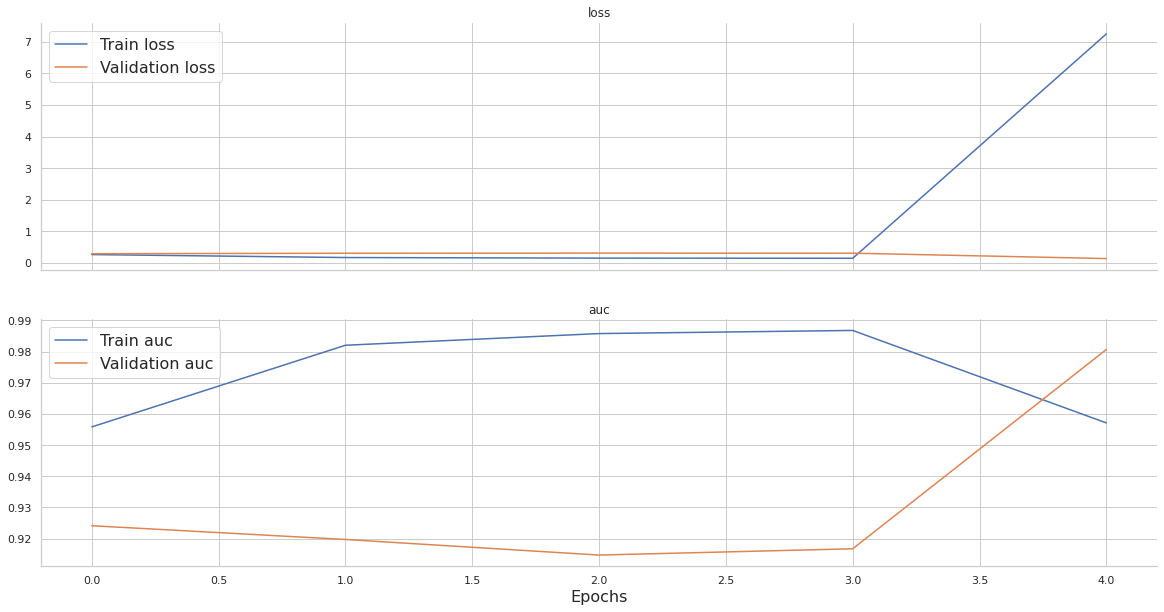

In [8]:
plot_metrics(history)

# Model evaluation

In [9]:
display(evaluate_model_single_fold(k_fold, fold_n, label_col='toxic_int').style.applymap(color_map))

,Train,Valid,Var,Train_fold_5,Valid_fold_5
Metric,,,,,
ROC AUC,0.951592,0.924500,0.027091,0.951592,0.924500
Accuracy,0.946330,0.922386,0.023944,0.946330,0.922386
Precision,0.882834,0.850451,0.032382,0.882834,0.850451
Recall,0.967377,0.930843,0.036534,0.967377,0.930843
F1-score,0.923174,0.888833,0.034340,0.923174,0.888833
Support,106888.000000,26722.000000,80166.000000,106888.000000,26722.000000


# Confusion matrix

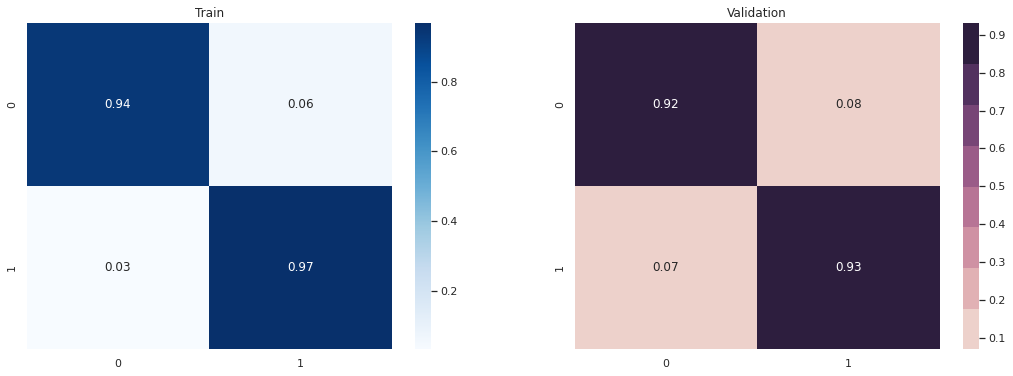

In [10]:
train_set = k_fold[k_fold[f'fold_{fold_n}'] == 'train']
validation_set = k_fold[k_fold[f'fold_{fold_n}'] == 'validation'] 
plot_confusion_matrix(train_set['toxic_int'], train_set[f'pred_{fold_n}'], 
                      validation_set['toxic_int'], validation_set[f'pred_{fold_n}'])

# Model evaluation by language

In [11]:
display(evaluate_model_single_fold_lang(valid_df, fold_n).style.applymap(color_map))
# ML fine-tunned preds
display(evaluate_model_single_fold_lang(valid_df, fold_n, pred_col='pred_ml').style.applymap(color_map))

,Mean,Fold_5
Lang / ROC AUC,,
Overall,0.922622,0.922622
es,0.901503,0.901503
it,0.887481,0.887481
tr,0.980274,0.980274


,Mean,Fold_5
Lang / ROC AUC,,
Overall,0.980987,0.980987
es,0.970068,0.970068
it,0.969693,0.969693
tr,0.995550,0.995550


# Visualize predictions

In [12]:
pd.set_option('max_colwidth', 120)
print('English validation set')
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

print('Multilingual validation set')
display(valid_df[['comment_text', 'toxic'] + [c for c in valid_df.columns if c.startswith('pred')]].head(10))

English validation set


,comment_text,toxic,pred_5
0,And you have something alien on your lips Chance. Geez dude give it up. Better yet why don't you ask the Krotch brot...,0.000000,0.0
1,no income tax for anyone that comes and works and leaves. no income tax for retirees that come and work and leave. n...,0.166667,0.0
2,"Rubbish, Brandon. Nothing stopped Comey of the FBI of dumping the phony story about a new investigation in Hillary's...",0.833333,1.0
3,poster I have sent the e-mail. -Garrett,0.000000,0.0
4,== ECB exposure == I responded to a comment of yours here. Cheers.,0.000000,0.0
5,"You said, Let's keep abortion safe. Did you mean safe for the mom, or safe for the baby? God forgives women (and men...",0.200000,0.0
6,I was responding to Gary (and others) and the letter writer. I believe Christians would be slow to act in this situa...,0.000000,0.0
7,Now you disagree with your own comment?,0.000000,0.0
8,Amarista definitely needs to go away. If for no other reason than the best poster on this site Northsider will see h...,0.000000,0.0
9,"Corspefucking Art I used their offical website as help to gte al information right. Therefore, some sentences were l...",1.000000,0.0


Multilingual validation set


,comment_text,toxic,pred_5,pred_ml_5
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,0,0.858288,0.529086
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",0,0.000944,0.011122
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",1,0.957752,0.888410
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,0,0.000023,0.000020
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,0,0.000362,0.000762
5,"güzel, zaten kaynaklandırması zor subjektif kategoriler bunlar. bazı maddelerden çıkartmak, kiminden çıkartıp kimind...",0,0.000160,0.000331
6,"No es mala idea. De hecho, yo estaba pensando descolgarme ya del reto mensual, pero esto vuelve a ilusionarme. El pr...",0,0.000011,0.000004
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık çok teşekkürler.Önceki sürümleri araştırdım.13 Haziran 2010 da Kullanıc...",0,0.000790,0.000611
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umarım her şey istediğin gibidir. Bu arada Janet Jackson maddesi seçkin ma...,0,0.000472,0.000699
9,"Creo que es importante que podamos reconocer a gente como Victor Manuel Vucetich , quien es originario de Tampico y ...",0,0.000067,0.000060


# Test set predictions

In [13]:
x_test = np.load(database_base_path + 'x_test.npy')
test_preds = model.predict(get_test_dataset(x_test, config['BATCH_SIZE'], AUTO))

In [14]:
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = test_preds
submission.to_csv('submission.csv', index=False)

display(submission.describe())
display(submission.head(10))

,id,toxic
count,63812.000000,63812.000000
mean,31905.500000,0.220903
std,18421.082026,0.333606
min,0.000000,0.000000
25%,15952.750000,0.000137
50%,31905.500000,0.004904
75%,47858.250000,0.377021
max,63811.000000,1.000000


,id,toxic
0,0,0.000152
1,1,0.001284
2,2,0.472212
3,3,0.000331
4,4,0.000239
5,5,0.046692
6,6,0.000027
7,7,0.000390
8,8,0.060758
9,9,0.314050
